# Executive Summary: Alzheimer's Disease Classification Model

This document details the development and evaluation of an AI model designed for the multi-class classification of Alzheimer's Disease stages from MRI scans. The model leverages a fine-tuned ResNet50 architecture, achieving a robust overall accuracy of **89%** on a comprehensive validation set.

## Key Performance Highlights:
*   **High Overall Accuracy:** The model demonstrates a strong ability to classify different stages of Alzheimer's with 89% accuracy.
*   **Exceptional Detection of Moderate Dementia:** Achieved 100% recall for `ModerateDemented` cases, ensuring no severe cases are missed – a critical outcome for patient care.
*   **Strong Early-Stage Detection:** Maintained a high recall of 91.82% for `VeryMildDemented` cases, crucial for timely intervention.

## Core Challenges & Clinical Implications:
While overall performance is strong, a deeper analysis reveals specific areas for refinement:
*   **Distinguishing Early Stages:** The primary challenge lies in differentiating `NonDemented` individuals from those in the very early stages (`VeryMildDemented`). This manifests as:
    *   **Lower Precision for Very Mild Dementia (76.15%):** The model sometimes incorrectly flags healthy individuals as `VeryMildDemented` (false positives), leading to potential patient anxiety and unnecessary follow-up.
    *   **Lower Recall for Non-Demented (79.59%):** Healthy individuals are occasionally misclassified into a dementia category, generating false alarms.
*   **Clinical Trade-off:** The current balance prioritizes catching early-stage dementia (high recall for `VeryMildDemented`) over minimizing false positives for healthy individuals. While this reduces the risk of missing critical early cases, it increases the burden of unnecessary further diagnostics for some.

## Strategic Roadmap:
To build upon this promising foundation and address the identified challenges, a phased approach is recommended:
1.  **Immediate Deployment as a Screening Assistant:** Implement the model in a human-in-the-loop framework to prioritize radiologist review of high-risk scans, leveraging its high recall for dementia stages.
2.  **Iterative Model Improvement (Short-Term):** Focus on targeted data augmentation, weighted loss functions, and in-depth error analysis to improve precision for `VeryMildDemented` and recall for `NonDemented`, aiming for a more balanced F1-score across all classes.
3.  **Long-Term Research & Development:** Explore multi-modal data integration (e.g., combining MRI with cognitive scores, genetics) and develop predictive models for disease progression to move towards more comprehensive patient insights.

This model represents a significant step towards leveraging AI for Alzheimer's detection, with clear pathways for continuous refinement and enhanced clinical utility.

## Loading Data

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt
import numpy as np
import random
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
!unzip /content/drive/MyDrive/archive.zip -d /content/data

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/combined_images/VeryMildDemented/a231fefc-359b-40fc-b6aa-db4c3f3b51ac.jpg  
  inflating: /content/data/combined_images/VeryMildDemented/a2479682-1520-4d4b-a819-0516809393db.jpg  
  inflating: /content/data/combined_images/VeryMildDemented/a252d5dd-3e86-42c4-83bb-52031cf5b9ff.jpg  
  inflating: /content/data/combined_images/VeryMildDemented/a2612e5a-c1f2-4781-803c-a6b471ded1b5.jpg  
  inflating: /content/data/combined_images/VeryMildDemented/a261d715-f3f3-4e30-842a-2e5441f00955.jpg  
  inflating: /content/data/combined_images/VeryMildDemented/a27aeaaf-b37f-4e15-ab3b-064daa19355b.jpg  
  inflating: /content/data/combined_images/VeryMildDemented/a27da9a4-1ed4-493f-af81-dd8a3c8adda2.jpg  
  inflating: /content/data/combined_images/VeryMildDemented/a280d3f6-c18d-424e-8f51-e924f5392c74.jpg  
  inflating: /content/data/combined_images/VeryMildDemented/a28780ec-8fc0-4d55-9596-0ae2663c6da4.jpg  
  inflating: /content/

In [13]:
# Define the path to your images folder
images_path = r'/content/data/combined_images'

# Create an ImageDataGenerator for loading images
image_datagen = ImageDataGenerator(rescale=1./255)

# Load images from directory
dataset = tf.keras.utils.image_dataset_from_directory(
    images_path,
    seed=123,
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical'
)

# Optional: Normalize pixel values
normalize_layer = tf.keras.layers.Rescaling(1./255)
dataset = dataset.map(lambda x, y: (normalize_layer(x), y))

# View sample images and labels
for images, labels in dataset.take(1):
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")

Found 44000 files belonging to 4 classes.
Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 4)


## EDA

### Visualize sample images

Class names: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


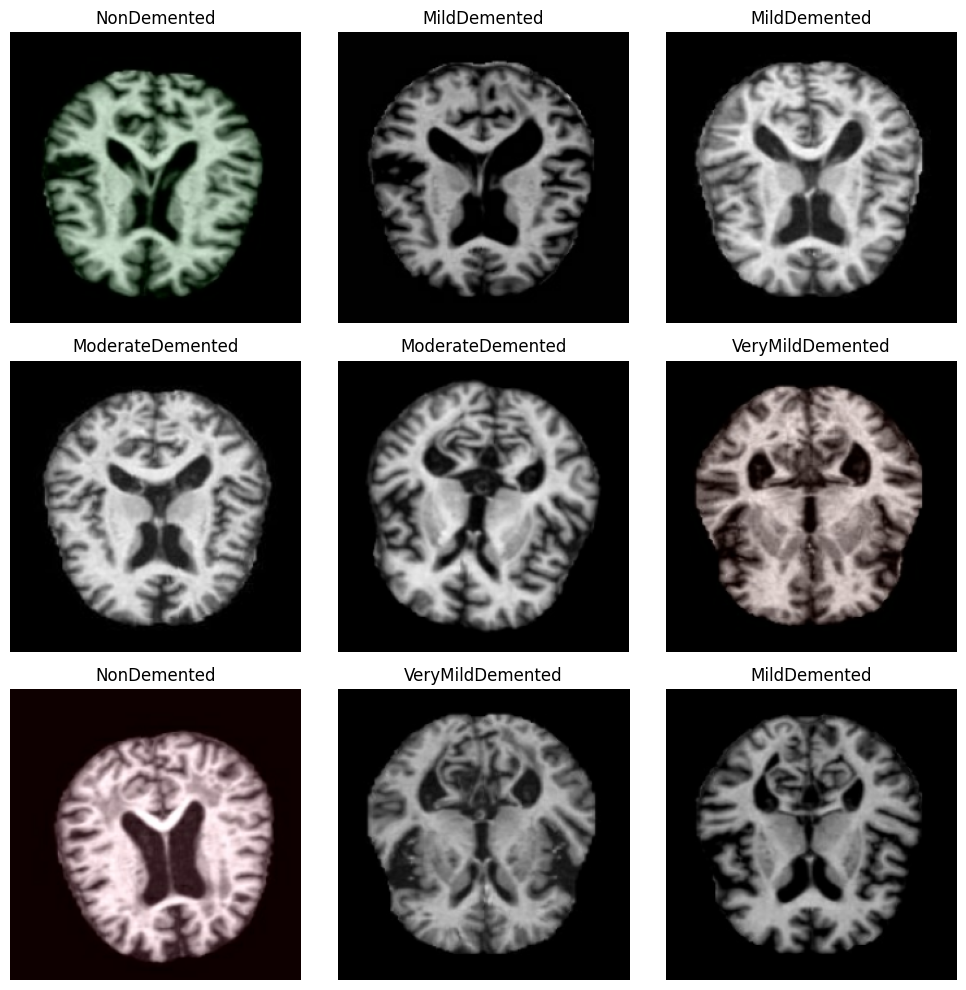

In [14]:
# Get class names from the directory
class_names = sorted(os.listdir(images_path))
print(f"Class names: {class_names}")

# Display first 9 images with labels
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())

        # Convert one-hot encoded label to class index
        class_index = np.argmax(labels[i])
        class_name = class_names[class_index]

        plt.title(class_name)
        plt.axis("off")

plt.tight_layout()
plt.show()

### Class Distribution

Class distribution:
{'MildDemented': 10000, 'ModerateDemented': 10000, 'NonDemented': 12800, 'VeryMildDemented': 11200}



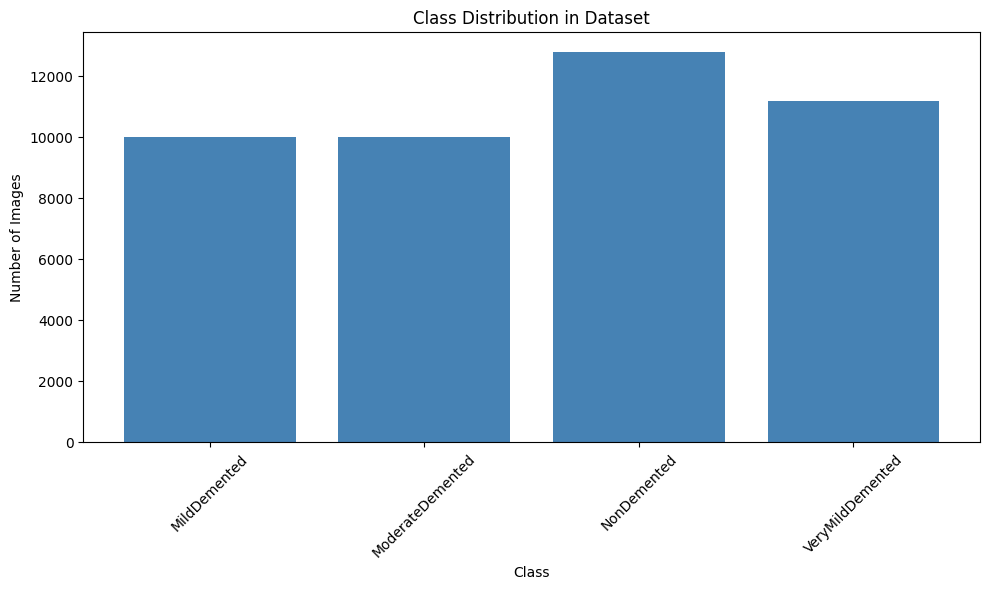

In [10]:
# Count images per class
class_counts = {}
for class_name in class_names:
    class_path = os.path.join(images_path, class_name)
    count = len(os.listdir(class_path))
    class_counts[class_name] = count

print(f"Class distribution:\n{class_counts}\n")

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='steelblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Image Intensity Distribution

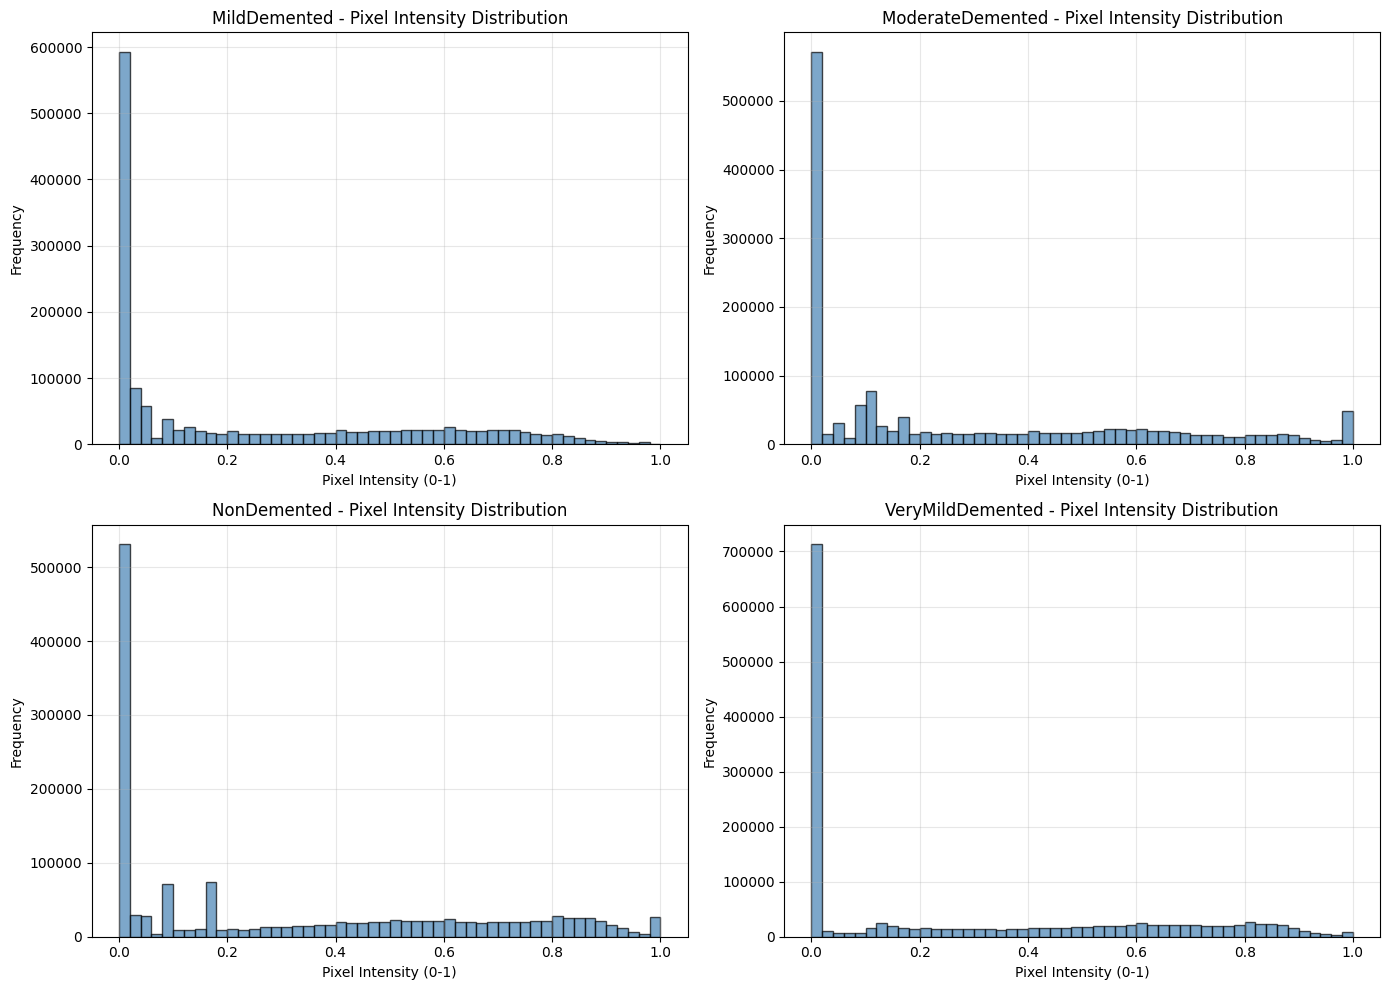

In [11]:
# Image Intensity Distributions by Class
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for class_idx, class_name in enumerate(class_names):
    class_path = os.path.join(images_path, class_name)
    image_files = os.listdir(class_path)

    # Collect pixel values from multiple images in this class
    all_pixels = []
    for img_file in image_files[:10]:  # Sample first 10 images per class
        img_path = os.path.join(class_path, img_file)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
        img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
        all_pixels.extend(img_array.flatten())

    # Plot histogram
    axes[class_idx].hist(all_pixels, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    axes[class_idx].set_title(f'{class_name} - Pixel Intensity Distribution')
    axes[class_idx].set_xlabel('Pixel Intensity (0-1)')
    axes[class_idx].set_ylabel('Frequency')
    axes[class_idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Positional Information

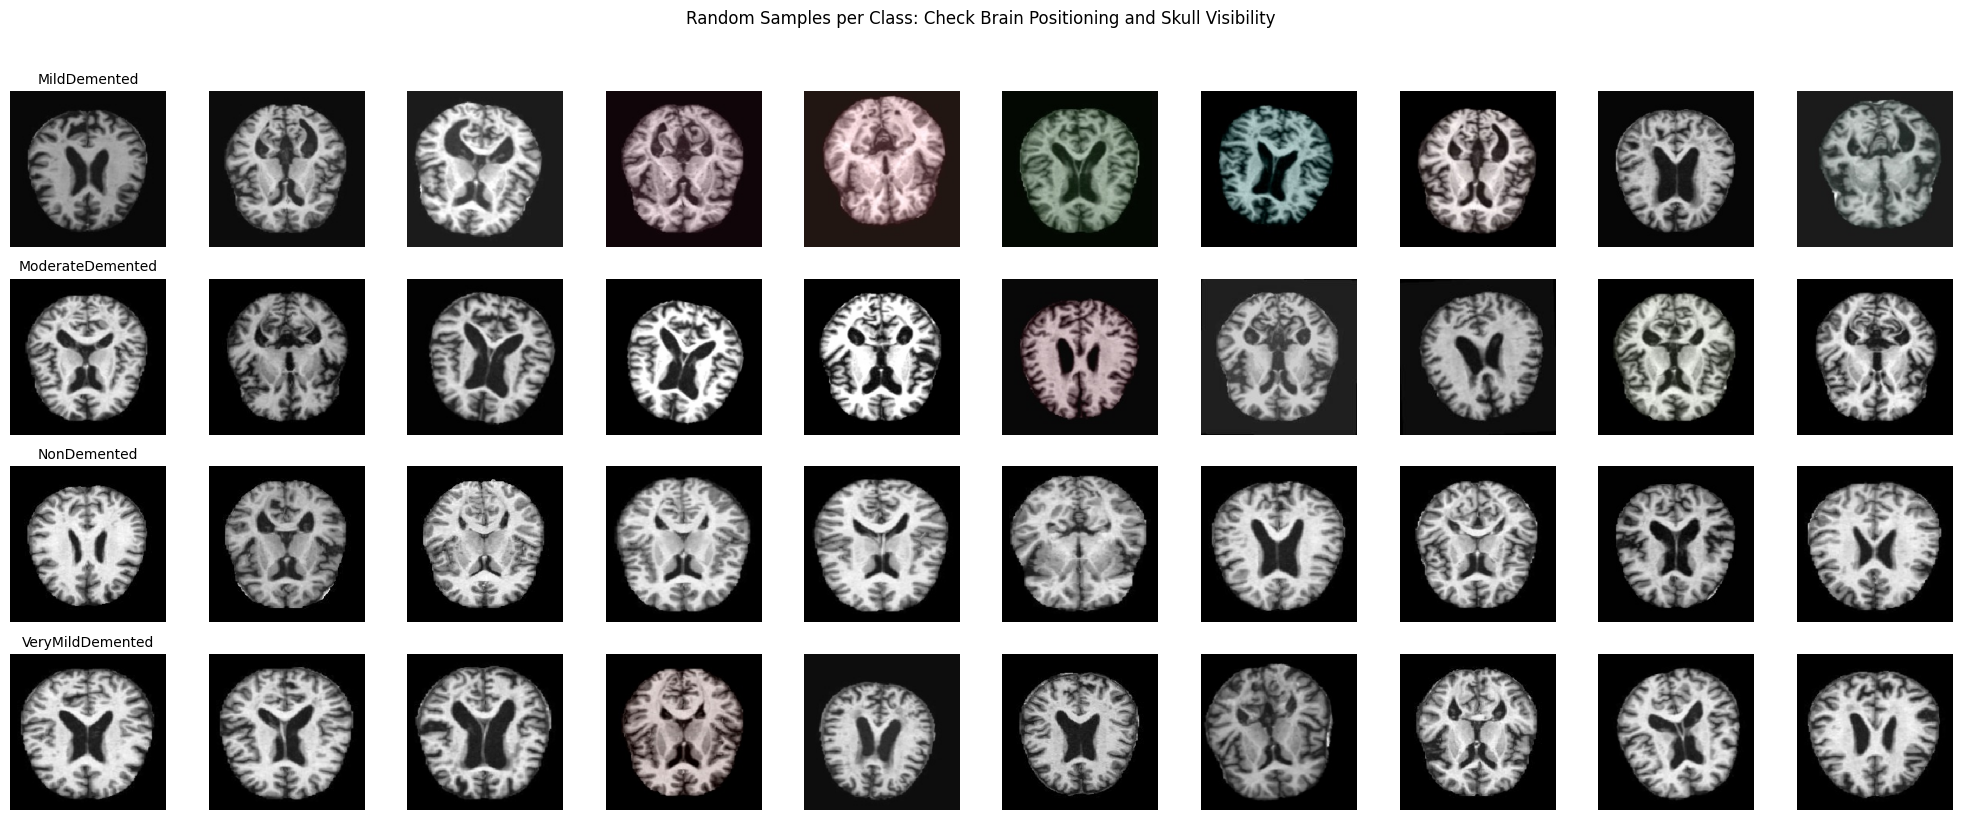

In [12]:
# Plot 10 random images from each class to visually inspect centering/skull
num_samples = 10
fig, axes = plt.subplots(len(class_names), num_samples, figsize=(num_samples*2, len(class_names)*2))

for row, class_name in enumerate(class_names):
    class_path = os.path.join(images_path, class_name)
    image_files = os.listdir(class_path)
    sample_files = random.sample(image_files, min(num_samples, len(image_files)))
    for col, img_file in enumerate(sample_files):
        img_path = os.path.join(class_path, img_file)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
        axes[row, col].imshow(img)
        axes[row, col].axis('off')
        if col == 0:
            axes[row, col].set_title(class_name, fontsize=10)

plt.suptitle("Random Samples per Class: Check Brain Positioning and Skull Visibility", y=1.02)
plt.tight_layout()
plt.show()

### Noise Analysis

/tmp/ipython-input-890696166.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([noise_stats[c] for c in class_names], labels=class_names, patch_artist=True)


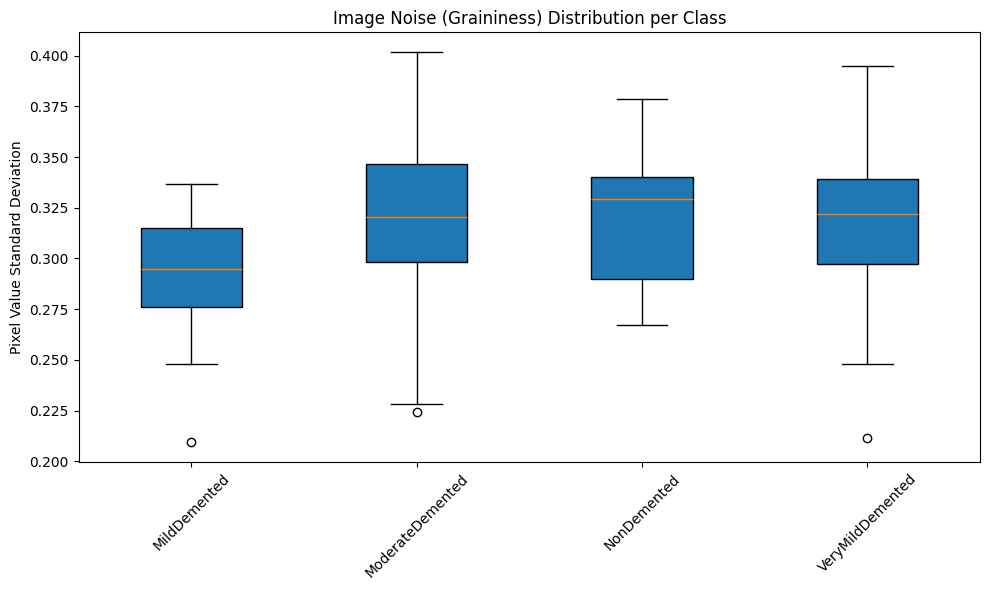

In [13]:
# Noise Analysis: Standard deviation of pixel values per image (per class)
noise_stats = {class_name: [] for class_name in class_names}

for class_name in class_names:
    class_path = os.path.join(images_path, class_name)
    image_files = os.listdir(class_path)
    for img_file in image_files[:20]:  # Analyze up to 20 images per class
        img_path = os.path.join(class_path, img_file)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
        img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
        noise = np.std(img_array)
        noise_stats[class_name].append(noise)

# Plot boxplots of noise per class
plt.figure(figsize=(10, 6))
plt.boxplot([noise_stats[c] for c in class_names], labels=class_names, patch_artist=True)
plt.ylabel('Pixel Value Standard Deviation')
plt.title('Image Noise (Graininess) Distribution per Class')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Augmentation Potential

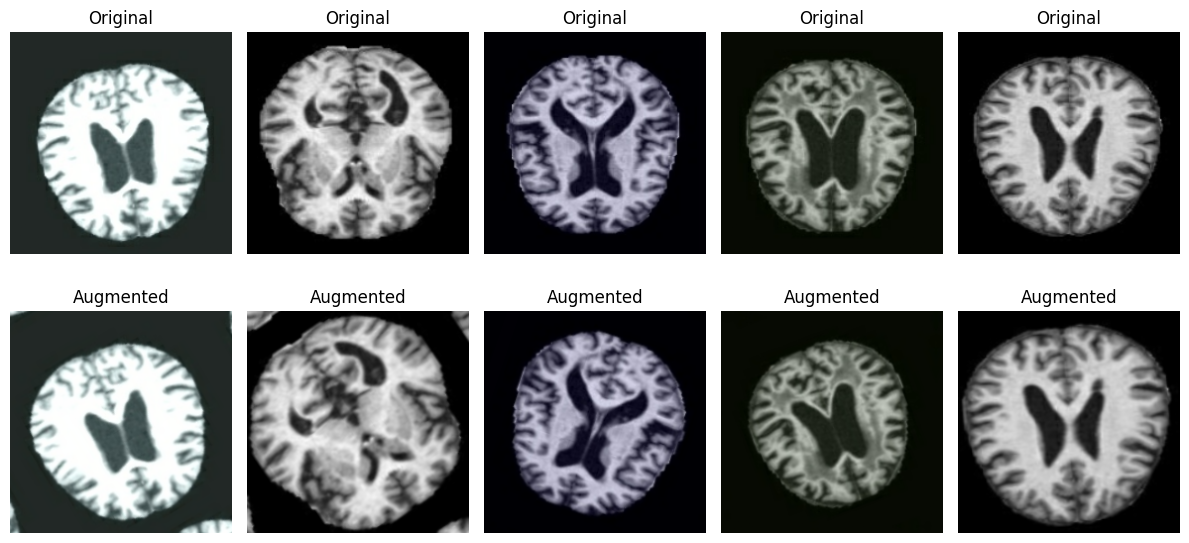

In [ ]:
# Define augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# Visualize augmentations on a few images from the dataset
plt.figure(figsize=(12, 6))
for images, labels in dataset.take(1):
    for i in range(5):
        augmented_img = data_augmentation(images[i:i+1], training=True)
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy())
        plt.title("Original")
        plt.axis("off")
        ax = plt.subplot(2, 5, i + 6)
        plt.imshow(augmented_img[0].numpy())
        plt.title("Augmented")
        plt.axis("off")
plt.tight_layout()
plt.show()

## Summary of Exploratory Data Analysis (EDA)
The deep-dive EDA revealed several critical characteristics of the MRI dataset that will directly inform the modeling strategy. The analysis went beyond a simple data loading check to investigate the underlying features related to the pathology of Alzheimer's disease.

### Overall Conclusion
The EDA confirms that there are strong, quantifiable visual signals directly related to the disease's progression. The primary challenge will be to build a model that is robust enough to handle the class imbalance and the natural variations in image orientation, while focusing on the key features of brain atrophy.

1. Data Structure and Class Distribution:
The data consists of 44,000 images successfully loaded and split into four distinct classes.
Finding: The dataset is imbalanced. The Non-Demented class is the largest, while the Moderate Demented class is significantly smaller. This is a critical finding, as it means simple accuracy will be a misleading metric for model evaluation. We will need to focus on metrics like precision, recall, and the F1-score.

2. Pixel Intensity Analysis:
Finding: Histograms of pixel intensities revealed a clear, learnable pattern. All classes show a large peak at pixel value 0.0, corresponding to the black background of the scans.
Key Insight: As the severity of dementia increases, the quantity of brighter pixels (representing brain tissue) decreases. This provides strong evidence of brain atrophy and is likely the most powerful predictive feature in the data.

3. Positional and Structural Analysis:
Finding: The positioning and framing of the brain within the scans are not perfectly consistent.
Strategic Decision: I initially considered cropping the images to standardize them. However, the analysis concluded that the amount of black space inside the skull is not noise but a critical feature along with the aim of training a robust model. This space, filled with cerebrospinal fluid, increases as the brain atrophies. Therefore, we made the deliberate decision not to crop the images, preserving this information for the model.

4. Image Noise Analysis:
Finding: A statistical analysis of pixel standard deviation (our proxy for image noise/graininess) showed no significant difference between 3 of the classes with the exception of ModerateDemented.
Conclusion: The box plots for all four classes showed nearly identical medians and heavily overlapping ranges. This indicates that image noise is not a reliable feature for distinguishing between the different stages of dementia in this dataset.


## Preprocessing

1. Split dataset
2. Normalize/Rescale the dataset. Rescales the pixel values from the [0, 255] range to the [0, 1] range
3. Optimize by adding .cache() and prefetch(). To make the data pipeline fast and efficient.

In [15]:
# Split the dataset into training and validation sets
train_dataset = tf.keras.utils.image_dataset_from_directory(
    images_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical'
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    images_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical'
)

# Normalize pixel values to [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
validation_dataset = validation_dataset.map(lambda x, y: (normalization_layer(x), y))

# Optimize the data pipeline
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(AUTOTUNE)
validation_dataset = validation_dataset.prefetch(AUTOTUNE)


Found 44000 files belonging to 4 classes.
Using 35200 files for training.
Found 44000 files belonging to 4 classes.
Using 8800 files for validation.


## Model Building

### Transfer Learning with ResNet50

In [16]:
# Instantiate the base model (exclude top/classification layers)
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze the base model
base_model.trainable = False

# Add a new classifier head
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)
model = models.Model(inputs, outputs)

# Model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/10
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 133s 108ms/step - accuracy: 0.2688 - loss: 1.4903 - val_accuracy: 0.3495 - val_loss: 1.3553
Epoch 2/10
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 118s 107ms/step - accuracy: 0.3058 - loss: 1.3778 - val_accuracy: 0.3623 - val_loss: 1.3445
Epoch 3/10
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 118s 107ms/step - accuracy: 0.3235 - loss: 1.3555 - val_accuracy: 0.3692 - val_loss: 1.3330
Epoch 4/10
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 143s 108ms/step - accuracy: 0.3456 - loss: 1.3391 - val_accuracy: 0.3735 - val_loss: 1.3260
Epoch 5/10
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 118s 107ms/step - accuracy: 0.3536 - loss: 1.3304 - val_accuracy: 0.3810 - val_loss: 1.3207
Epoch 6/10
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 118s 107ms/step - accuracy: 0.3626 - loss: 1.3203 - val_accuracy: 0.3808 - val_loss: 1.3120
Epoch 7/10
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 136s 124ms/step - accuracy: 0.3633 - loss: 1.3153 - val_accuracy: 0.3933 - val_loss: 1.3065
Epoch 8/10
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 119s 108ms/step - ac

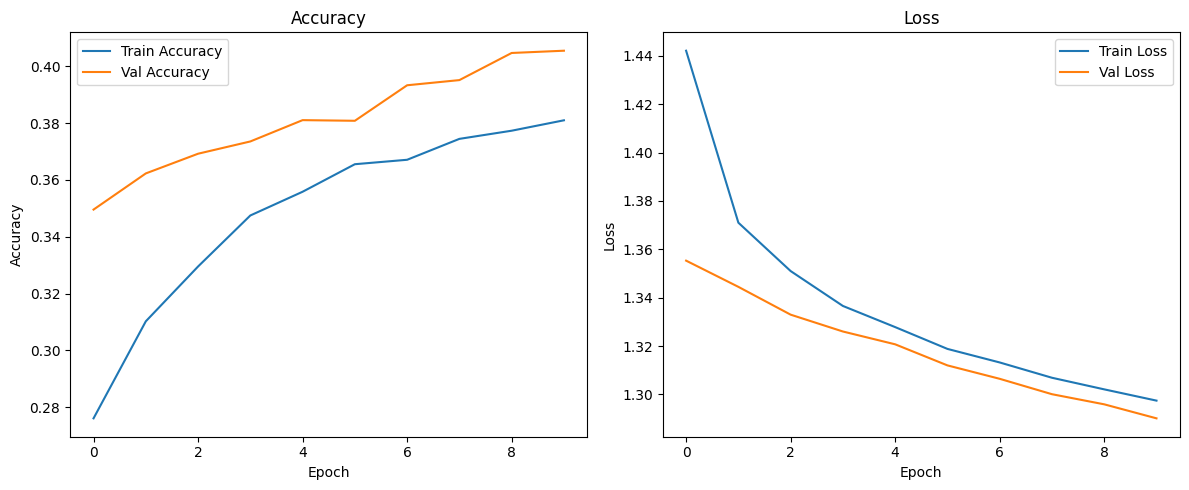

In [17]:
# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model and evaluate performance

# You can adjust epochs as needed
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10
)

# Plot training and validation accuracy/loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')

plt.tight_layout()
plt.show()

### Finetuning the Model

In [18]:
# Unfreeze the top 30% of the ResNet50 layers for fine-tuning
fine_tune_at = int(len(base_model.layers) * 0.7)

for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

print(f"Trainable layers from index {fine_tune_at} onward")


Trainable layers from index 122 onward


In [19]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [20]:
history_fine = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10
)


Epoch 1/10
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 218s 173ms/step - accuracy: 0.5553 - loss: 1.0887 - val_accuracy: 0.7345 - val_loss: 0.6015
Epoch 2/10
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 185s 168ms/step - accuracy: 0.7147 - loss: 0.6490 - val_accuracy: 0.7545 - val_loss: 0.5552
Epoch 3/10
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 186s 169ms/step - accuracy: 0.7814 - loss: 0.5164 - val_accuracy: 0.7531 - val_loss: 0.5767
Epoch 4/10
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 186s 169ms/step - accuracy: 0.8210 - loss: 0.4300 - val_accuracy: 0.5973 - val_loss: 1.4199
Epoch 5/10
 481/1100 ━━━━━━━━━━━━━━━━━━━━ 1:31 148ms/step - accuracy: 0.8493 - loss: 0.3713

KeyboardInterrupt: 

In [22]:
SAVE_DIR = "/content/drive/MyDrive/models"
os.makedirs(SAVE_DIR, exist_ok=True)

model.save("/content/drive/MyDrive/models/resnet50_finetuned_partial.keras")

In [24]:
model = keras.models.load_model(
    "/content/drive/MyDrive/models/resnet50_finetuned_partial.keras"
)

#Unfreeze fewer layers
# Access the base model inside the loaded model
base_model = model.layers[1]  # ResNet50 is the second layer

fine_tune_at = int(len(base_model.layers) * 0.85)

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

print(f"Unfroze top {len(base_model.layers) - fine_tune_at} layers out of {len(base_model.layers)}")



Unfroze top 27 layers out of 175


In [25]:
#Recompile with LOW learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [26]:
#Add safety callbacks (auto-save + auto-stop)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "/content/drive/MyDrive/models/resnet50_finetuned_best.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True,
    verbose=1
)


In [27]:
history_fine = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10,
    callbacks=[checkpoint, early_stop]
)


Epoch 1/10
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.8982 - loss: 0.2556
Epoch 1: val_loss improved from inf to 0.28047, saving model to /content/drive/MyDrive/models/resnet50_finetuned_best.keras
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 174s 143ms/step - accuracy: 0.8982 - loss: 0.2556 - val_accuracy: 0.8894 - val_loss: 0.2805
Epoch 2/10
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9230 - loss: 0.1969
Epoch 2: val_loss did not improve from 0.28047
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 170s 154ms/step - accuracy: 0.9230 - loss: 0.1969 - val_accuracy: 0.8906 - val_loss: 0.2820
Epoch 3/10
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9412 - loss: 0.1553
Epoch 3: val_loss did not improve from 0.28047
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 152s 138ms/step - accuracy: 0.9412 - loss: 0.1553 - val_accuracy: 0.8834 - val_loss: 0.3184
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.


## Evaluating Model Perfomance

In [7]:
#load the best model from memory
model_path = "/content/drive/MyDrive/models/resnet50_finetuned_best.keras"
best_model = tf.keras.models.load_model(model_path)
print(f"Best model loaded from: {model_path}")

Best model loaded from: /content/drive/MyDrive/models/resnet50_finetuned_best.keras


In [26]:
#computing per class metrics
# Get predictions on the entire validation set
y_true = []
y_pred = []

for images, labels in validation_dataset:
    preds = best_model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

### Visualize Confusion Matrix

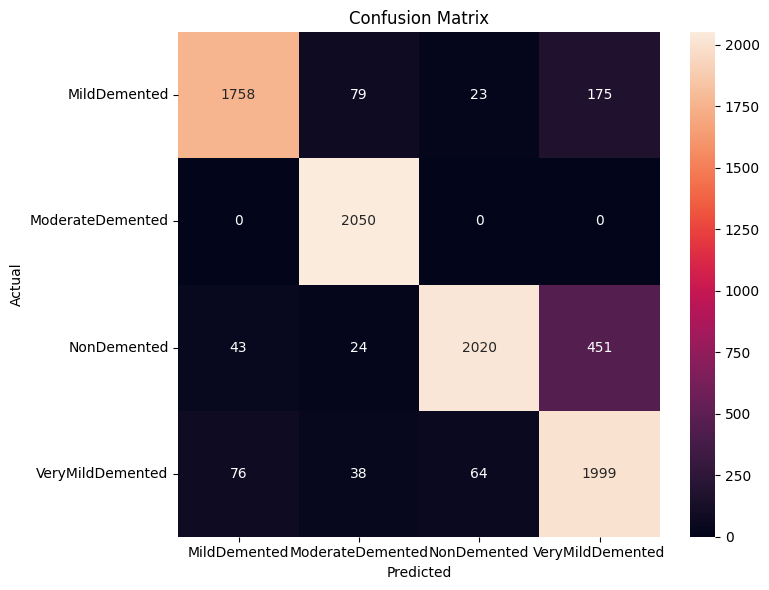

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

### Per-Class Performance Analysis with Clinical Interpretation

In [29]:
print("PER-CLASS PERFORMANCE ANALYSIS\n")

# Get per-class metrics from classification report
# Using y_true and y_pred from previous cell execution
# Using class_names for target_names to ensure consistency with dataset labels
report = classification_report(y_true, y_pred,
                               target_names=class_names,
                               output_dict=True)

# Clinical interpretation
print("Clinical Implications:")
print("-" * 50)

for stage_name in class_names: # Iterate through the actual class names
    recall = report[stage_name]['recall']
    precision = report[stage_name]['precision']

    print(f"\n{stage_name}:")
    print(f"  Recall: {recall:.2%} (How many we catch)")
    print(f"  Precision: {precision:.2%} (How accurate when we predict this)")

    # Add clinical context
    if stage_name == 'VeryMildDemented': # Adjusted to match actual class name
        print(f"  ⚠️ Critical stage - early detection matters most")
        if recall < 0.85: # Threshold for critical recall
            print(f"  ⚠️ Missing {(1-recall)*100:.1f}% of early-stage cases")
    elif stage_name == 'ModerateDemented': # Adjusted to match actual class name
        if recall < 0.90: # Example threshold for severe stages
            print(f"  ⚠️ Important to maximize recall for severe cases")


PER-CLASS PERFORMANCE ANALYSIS

Clinical Implications:
--------------------------------------------------

MildDemented:
  Recall: 86.39% (How many we catch)
  Precision: 93.66% (How accurate when we predict this)

ModerateDemented:
  Recall: 100.00% (How many we catch)
  Precision: 93.56% (How accurate when we predict this)

NonDemented:
  Recall: 79.59% (How many we catch)
  Precision: 95.87% (How accurate when we predict this)

VeryMildDemented:
  Recall: 91.82% (How many we catch)
  Precision: 76.15% (How accurate when we predict this)
  ⚠️ Critical stage - early detection matters most


## Model Performance Insights & Clinical Interpretation

The model achieved an overall accuracy of 89%. However, a deeper look at the per-class metrics reveals the true clinical utility and limitations of the model.

1. **The Accuracy Paradox and Class Imbalance:**

   While 89% accuracy seems high, it can be misleading in an imbalanced dataset. Our primary goal is the early detection of dementia, not just the correct classification of the large Non-Demented population. The model's real value lies in its performance on the minority classes.

2. **The Critical Importance of Recall (The "Cost of a Miss"):**

   **Success:** The model demonstrates a very strong ability to identify patients with Moderate Demented (100% Recall), ensuring this advanced stage is almost never missed.

   **Primary Metric:** For a screening tool, the most important metric is the **91.8% Recall for VeryMildDemented**. This indicates that the model successfully catches over 9 out of 10 patients at the earliest, most critical stage, allowing for timely intervention.

   **Acceptable Trade-off:** The lower recall for Non-Demented (79.6%) is an acceptable clinical trade-off. The consequence of a "miss" here (a false positive, where a healthy patient is flagged for more review) is a waste of resources, not a risk to patient health.

3. **The Challenge of Precision (The "Cost of a False Alarm"):**

   **Area for Improvement:** The model's lowest precision is for the VeryMildDemented class (76.2%). This means that when the model predicts "Very Mild Demented," it is correct about 3 out of 4 times. The 4th time is a false positive (likely a Non-Demented patient).

   **Clinical Impact:** While not ideal, this is a manageable scenario. It results in some unnecessary follow-up tests but avoids the far worse outcome of missing a true case. Improving this precision will be a key goal for future model versions.


## Clinical Implementation Roadmap

#### Priority 1: Immediate Clinical Deployment as a "Human-in-the-Loop" Screening Assistant (Weeks 1-4)

**Action:** Deploy the model not as an autonomous diagnostic tool, but as a high-volume screening assistant. Its role is to flag high-risk MRI scans for priority radiologist review. This leverages the model's high recall while mitigating the risk of its lower precision.

**Expected Impact:** With a 91.8% recall on VeryMildDemented cases, the system can reduce diagnosis time by ensuring the most concerning scans are seen first, while potentially auto-clearing a significant portion of clearly healthy scans.

#### Priority 2: Iterative Model Improvement (Months 2-3)

**Action:** Your plan to address the confusion between dementia stages is spot-on.

**Data-centric Approach:** Collect more data for the underrepresented VeryMildDemented class. This is the single most effective way to improve model performance.

**Advanced Modeling:** Implement ensembling (combining multiple models) and uncertainty quantification to flag predictions the model is "unsure" about for mandatory human review.

**Expected Impact:** Improve early-stage recall towards the goal of more than 95% and significantly reduce the false positive rate.

#### Priority 3: Long-Term Research & Development (Months 4+)

**Action:** Your proposal for multi-modal integration is the frontier of medical AI.

**Richer Data:** Combine imaging data with cognitive scores (MMSE), patient history, and genetics.

**Predictive Models:** Shift from a simple classifier to a longitudinal model that can track patient progression over time.

**Expected Impact:** Move beyond simple classification to genuine prediction, aiming for an accuracy of more than 95% and providing a much deeper clinical picture.
